importing necessary libreries

In [1]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from matplotlib import pyplot
from keras.datasets import fashion_mnist
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam ,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

ploting some pictures from fashion mnist dataset

In [2]:
def show_fashionmnist_pictures ():

	(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

	print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
	print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

	for i in range(9):
		
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'),aspect='auto')
	
	pyplot.show()

run the 'show_fashionmnist_pictures' function 

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


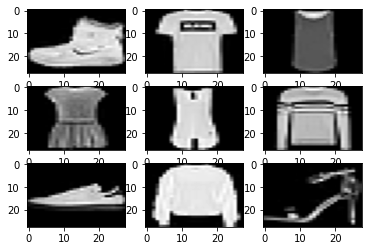

In [3]:
show_fashionmnist_pictures ()

the below function will make the dataset ready for our work

In [4]:
def data_preprocessing():

  (trainX, trainy ), (testX, testy) = fashion_mnist.load_data()

  #reshaping the data 
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX =  testX.reshape((testX.shape[0], 28, 28, 1))
  
  #convert from integer to float to prevent from the error
  trainX = trainX.astype('float32')
  testX =  testX.astype('float32')
  

  #normalize the data
  trainX /= 255.0
  testX /= 255.0
  

  trainy = to_categorical(trainy)
  testy = to_categorical(testy)

  return trainX, trainy, testX, testy

run the 'data_preprocessing' function 

In [5]:
trainX, trainy, testX, testy = data_preprocessing()

define the body of our model 

In [6]:
def define_model():
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last', input_shape=(28,28,1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))


  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last', input_shape=(28,28,1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))

  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [7]:
model = define_model()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 64)          256       
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [9]:
def save_model():

  trainX, trainy, testX, testy = data_preprocessing()

  model = define_model()

  model.fit(trainX,trainy, epochs=1, batch_size=32, verbose=0)
  model.save('final_model.h5')


implementing k_fold cross validation

In [10]:
def evaluate_model(x, y, num_folds=5):
  scores = []
  histories = []
  loss_train_list = []
  loss_test_list = []
  

  kfold = KFold(5, shuffle=True, random_state=1)

  for train, test in kfold.split(x):
  
    # define model
    model = define_model()
  
   
    trainX, trainy, testX, testy = x[train], y[train], x[test], y[test]
    
    # fit model
    network_history = model.fit(trainX, trainy, epochs=3, batch_size=32, validation_data=(testX,testy), verbose=0)
    
    
    _, acc = model.evaluate(testX, testy, verbose=0)
    print('> %.3f' % (acc * 100.0))
    

    
    scores.append(acc)
    histories.append(network_history)

   


    
  
  return scores  , histories

plot the classification accuracy

In [11]:
def show_loss_and_entropy(histories):
  for i in range(len(histories)):
    
  
    
    
    pyplot.title('Classification Accuracy')
    pyplot.plot(histories[i].history['accuracy'], color='green', label='train')
    pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  
  pyplot.show()
  

  
  
    


  
  


In [12]:
#load the dataset
trainX, trainy, testX, testy = data_preprocessing()

print('the result of validation with k_fold is ')
scores, histories = evaluate_model(trainX, trainy)

the result of validation with k_fold is 
> 89.017
> 89.450
> 89.292
> 88.142
> 88.958


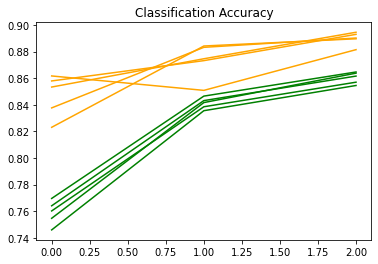

In [13]:
show_loss_and_entropy(histories)

save the model

In [14]:
save_model()

model = load_model('final_model.h5')


 plot the confusion matrix

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

run the confusion matrix

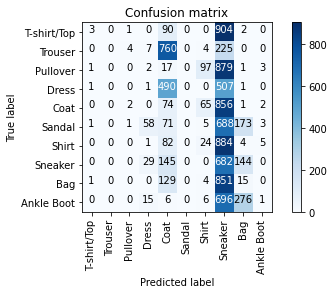

In [16]:
trainX, trainy, testX, testy = data_preprocessing()

#creat model
model = define_model()
    
    
Y_pred = model.predict(testX)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(testy,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])